<p style="text-align:center;">
<img src="https://resources.digitalfutures.com/data-science/datascience-notebook-header.png"
     alt="DigitalFuturesLogo"
     style="float: center;" />
</p>
<p style="text-align:center;">
<img src="./resources/international-civil-aviation-organization-icao-vector-logo.png"
     alt="ICAOLogo"
     style="float: center;"
     />
</p>

# ICAO Aircraft Engine Emissions Database

*by **Job Mathews***

A look into the Aircraft Engine Emission tests to analyse and see if I can find out which engines might be less environment-friendly or efficient among the different models of engines.

### Initialisation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# import matplotlib.gridspec as gridspec
# import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score

### Loading Data and Cleaning

In [2]:
ges_df = pd.read_csv('./Data/ges.csv', index_col='Unnamed: 0')

In [3]:
## Data preview
ges_df.head()

UID No  GSDB No             Manufacturer Engine Identification  \
0  1AS001        1            Allied Signal           TFE731-2-2B   
1  1AS002        1            Allied Signal              TFE731-3   
2  4AL003        4  Rolls-Royce Corporation               AE3007A   
3  6AL004        6  Rolls-Royce Corporation              AE3007C1   
4  6AL005        6  Rolls-Royce Corporation              AE3007A1   

  Combustor Description Eng Type  B/P Ratio  Pressure Ratio  \
0                   NaN       TF       2.64           13.90   
1                   NaN       TF       2.64           14.30   
2                   NaN      MTF       5.23           18.08   
3                   NaN      MTF       5.10           16.60   
4                Type 1      MTF       4.77           17.97   

   Rated Thrust (kN) Data Status  ... Final Test Date  \
0              15.60          PR  ...      1976-04-01   
1              16.50          PR  ...      1976-08-01   
2              33.73           C  ...      1995-04-19   
3              31.50           C  ...      1995-04-19   
4              34.91           R  ...      1995-04-19   

  Compliance with fuel venting requirements  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

                                            Remark 1  \
0           Not required to meet GASEOUS regulations   
1           Not required to meet GASEOUS regulations   
2                                                NaN   
3     Results based on Rolls Royce report EDR 15171B   
4  For effectivity see Rolls-Royce Notice to Oper...   

                                            Remark 2  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Results are based on Rolls-Royce report EDR 15...   

                                            Remark 3 Remark 4  Remark 5  \
0                                                NaN      NaN       NaN   
1                                                NaN      NaN       NaN   
2                                                NaN      NaN       NaN   
3                                                NaN      NaN       NaN   
4  AE3007A1 data in this report replace data repo...      NaN       NaN   

   Remark 6  Remark 7  Remark 8  
0       NaN       NaN       NaN  
1       NaN       NaN       NaN  
2       NaN       NaN       NaN  
3       NaN       NaN       NaN  
4       NaN       NaN       NaN  

[5 rows x 105 columns]

In [4]:
## Keeping the original dataframe untouched
df1 = ges_df.copy()

In [5]:
## Number of records and fields
df1.shape

(815, 105)

In [6]:
df1.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815 entries, 0 to 814
Data columns (total 105 columns):
 #    Column                                               Non-Null Count  Dtype  
---   ------                                               --------------  -----  
 0    UID No                                               815 non-null    object 
 1    GSDB No                                              815 non-null    int64  
 2    Manufacturer                                         815 non-null    object 
 3    Engine Identification                                815 non-null    object 
 4    Combustor Description                                625 non-null    object 
 5    Eng Type                                             815 non-null    object 
 6    B/P Ratio                                            807 non-null    float64
 7    Pressure Ratio                                       815 non-null    float64
 8    Rated Thrust (kN)                                    815 n

In [7]:
## Creating a dataframe for time based analysis.
temporal_analysis_df = df1[['B/P Ratio','Pressure Ratio','Rated Thrust (kN)','HC Dp/Foo Characteristic (g/kN)','CO Dp/Foo Characteristic (g/kN)','NOx Dp/Foo Characteristic (g/kN)','SN Characteristic','Initial Test Date']].dropna()

In [8]:
## Applying respective data types to the columns
# Converting dates to 'datetime' data type
df1['Initial Test Date'] = pd.to_datetime(df1['Initial Test Date'])
df1['Final Test Date'] = pd.to_datetime(df1['Final Test Date'])

# Converting categorical columns to 'category' data type
type_dict = {'Combustor Description': 'category',
             'Eng Type': 'category',
             'Fuel Spec': 'category'}
df1 = df1.astype(type_dict)
df1.dtypes

UID No                     object
GSDB No                     int64
Manufacturer               object
Engine Identification      object
Combustor Description    category
                           ...   
Remark 4                   object
Remark 5                   object
Remark 6                   object
Remark 7                   object
Remark 8                  float64
Length: 105, dtype: object

In [9]:
## Getting rid of rows with obsolete data that got superseded
counter = 0 # counting any superseding rows that may not exist in dataframe
s_counter = 0 # counting number of obsolete data rows ready to skip
supersede_list =  list(df1['Superseded by UID No'].unique())
uid_list =  list(df1['UID No'].unique())
# len(supersede_list), len(uid_list) # (247, 815)

for entry in supersede_list:
    if entry not in uid_list:
        print(f'Unskippable entry: {entry}')
        counter += 1
    else:
        s_counter += 1

print(f'Unskippable number of rows: {counter}. Number of rows that need to be skipped: {s_counter}.')

Unskippable entry: nan
Unskippable number of rows: 1. Number of rows that need to be skipped: 246.


In [10]:
## Dropping irrelevant rows
drop_index_list = []
drop_index_list.extend(list(df1[df1['Ambient Temp Max (K)'].isnull()].index)) # Getting the rows with null values in ambient conditions measurement
drop_index_list.extend(list(df1[~df1['Data Superseded'].isnull()].index)) # Getting the index numbers of the rows with obsolete data
drop_index_list = sorted(drop_index_list)
len(drop_index_list) # Number of rows to be dropped

266

In [11]:
## Dropping irrelevant rows
df1.drop(index=drop_index_list,inplace=True)

### EDA, Feature Selection and Engineering

In [12]:
## Averaging out columns to drop the extra columns
avg_dict = {'Ambient Pressure Avg (kPa)': ['Ambient Baro Min (kPa)','Ambient Baro Max (kPa)'],
            'Ambient Temp Avg (K)': ['Ambient Temp Min (K)','Ambient Temp Max (K)'],
            'Ambient Humidity Avg (kg/kg)': ['Humidity Min (kg/kg)','Humidity Max (kg/kg)'],
            'Fuel H/C Ratio Avg': ['Fuel H/C Ratio Min','Fuel H/C Ratio Max'],
            'Fuel Arom Avg': ['Fuel Arom Min (%)','Fuel Arom Max (%)'],
            'SN Range Avg': ['SN Range Min','SN Range Max']
            }
for ky,vl in avg_dict.items():
    df1[ky] = (df1[vl[0]] + df1[vl[1]])/2

In [13]:
df1.describe()

GSDB No   B/P Ratio  Pressure Ratio  Rated Thrust (kN)  \
count  551.000000  547.000000      551.000000         551.000000   
mean     8.328494    6.189935       29.768445         180.222760   
std      7.119952    2.683414        8.163487         112.088051   
min      1.000000    0.640000        9.760000           9.790000   
25%      2.000000    4.770000       24.500000          92.765000   
50%      7.000000    5.130000       29.300000         134.800000   
75%     12.000000    8.400000       35.195000         267.030000   
max     23.000000   12.721148       49.550928         513.900000   

       HC EI T/O (g/kg)  HC EI C/O (g/kg)  HC EI App (g/kg)  \
count        550.000000        551.000000        551.000000   
mean           0.083674          0.095939          0.474757   
std            0.148320          0.172317          1.460246   
min            0.000000          0.000000          0.000000   
25%            0.020000          0.020000          0.050000   
50%            0.040000          0.041000          0.080000   
75%            0.090000          0.100000          0.200000   
max            2.000000          2.000000         16.000000   

       HC EI Idle (g/kg)  HC Number Test  HC Number Eng  ...  \
count         551.000000      550.000000     550.000000  ...   
mean            4.697703        4.680000       2.236364  ...   
std            11.840788        3.148909       1.923525  ...   
min             0.000000        1.000000       1.000000  ...   
25%             0.377055        3.000000       1.000000  ...   
50%             1.540000        3.000000       1.000000  ...   
75%             3.915000        6.000000       3.000000  ...   
max           119.100000       18.000000      13.000000  ...   

       Ambient Temp Max (K)  Humidity Min (kg/kg)  Humidity Max (kg/kg)  \
count            551.000000            532.000000            532.000000   
mean             292.796715              0.004863              0.009242   
std                8.336543              0.004484              0.004664   
min              257.000000              0.000362              0.000530   
25%              287.000000              0.001675              0.006280   
50%              293.200000              0.003620              0.008300   
75%              299.000000              0.007000              0.012200   
max              313.000000              0.072500              0.021600   

       Remark 8  Ambient Pressure Avg (kPa)  Ambient Temp Avg (K)  \
count       0.0                  529.000000            551.000000   
mean        NaN                   99.514213            286.982332   
std         NaN                    1.731831              8.144776   
min         NaN                   95.150000            226.500000   
25%         NaN                   97.985000            282.550000   
50%         NaN                   99.350000            288.000000   
75%         NaN                  101.000000            291.950000   
max         NaN                  103.450000            304.500000   

       Ambient Humidity Avg (kg/kg)  Fuel H/C Ratio Avg  Fuel Arom Avg  \
count                    532.000000          517.000000     507.000000   
mean                       0.007053            2.097317      17.194813   
std                        0.003846            1.448305       1.513245   
min                        0.000530            1.850000      14.150000   
25%                        0.004130            1.900000      16.000000   
50%                        0.006750            1.920000      17.000000   
75%                        0.009800            1.935000      18.000000   
max                        0.041305           13.890000      21.850000   

       SN Range Avg  
count    328.000000  
mean       7.791502  
std        5.647777  
min        0.350000  
25%        3.352500  
50%        7.050000  
75%       11.700000  
max       48.250000  

[8 rows x 82 columns]

In [14]:
## Checking unique manufacturers
df1.Manufacturer.value_counts()

General Electric Company      159
Pratt & Whitney               126
CFM International              96
Rolls-Royce plc                78
International Aero Engines     18
Rolls-Royce Corporation        16
Pratt & Whitney Canada         13
Rolls-Royce Deutschland        12
Aviadvigatel                    8
Honeywell                       7
KKBM                            5
Textron Lycoming                4
IVCHENKO PROGRESS ZMBK          4
Allied Signal                   2
PowerJet S.A.                   2
Engine Alliance                 1
Name: Manufacturer, dtype: int64

In [15]:
## Grouping manufacturers

# <--------------- OLD CODE ---------------> #
# ge_list = ['General Electric Company', 'CFM International']
# rr_list = ['Rolls-Royce plc', 'Rolls-Royce Corporation', 'Rolls-Royce Deutschland']
# pw_list = ['Pratt & Whitney', 'International Aero Engines', 'Pratt & Whitney Canada']
# hw_list = ['Honeywell', 'Allied Signal']
# def group_manufacturers(val):
#     if val in ge_list:
#         return ge_list[0]
#     elif val in rr_list:
#         return rr_list[0]
#     elif val in pw_list:
#         return pw_list[0]
#     elif val in hw_list:
#         return f'{hw_list[0]} Aerospace'
#     else:
#         return 'Other'
# <----------- END OF OLD CODE -----------> #

manufacturer_dict = {'General Electric Company': ['General Electric Company', 'CFM International'],
                     'Rolls-Royce plc': ['Rolls-Royce plc', 'Rolls-Royce Corporation', 'Rolls-Royce Deutschland'],
                     'Pratt & Whitney': ['Pratt & Whitney', 'International Aero Engines', 'Pratt & Whitney Canada'],
                     'Honeywell Aerospace': ['Honeywell', 'Allied Signal']}

def group_manufacturers(val):
    entry_not_found = True
    for key,values in manufacturer_dict.items():
        if val in values:
            entry_not_found = False
            return key # Returning the manufacturing group name
    if entry_not_found:
        return 'Other' # Returning 'Other' for individual or ungrouped manufacturers


df1['Manufacturer_Group'] = df1.Manufacturer.apply(group_manufacturers)
# df1.head()

In [16]:
df1.Manufacturer_Group.value_counts()

General Electric Company    255
Pratt & Whitney             157
Rolls-Royce plc             106
Other                        24
Honeywell Aerospace           9
Name: Manufacturer_Group, dtype: int64

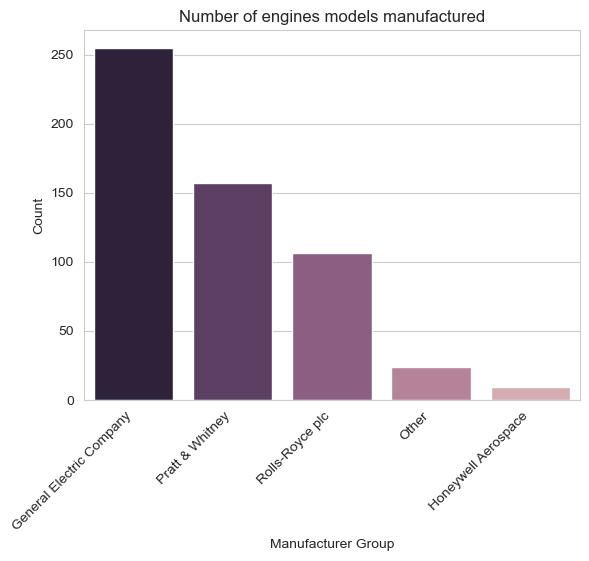

In [17]:
## Visualising the number of engine models from each group
sns.countplot(x=df1.Manufacturer_Group, palette=sns.cubehelix_palette(reverse=True), order=df1.Manufacturer_Group.value_counts().index)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Number of engines models manufactured')
plt.xlabel('Manufacturer Group')
plt.ylabel('Count')
# plt.savefig('manufacture.png',dpi=400, bbox_inches='tight')
plt.show()

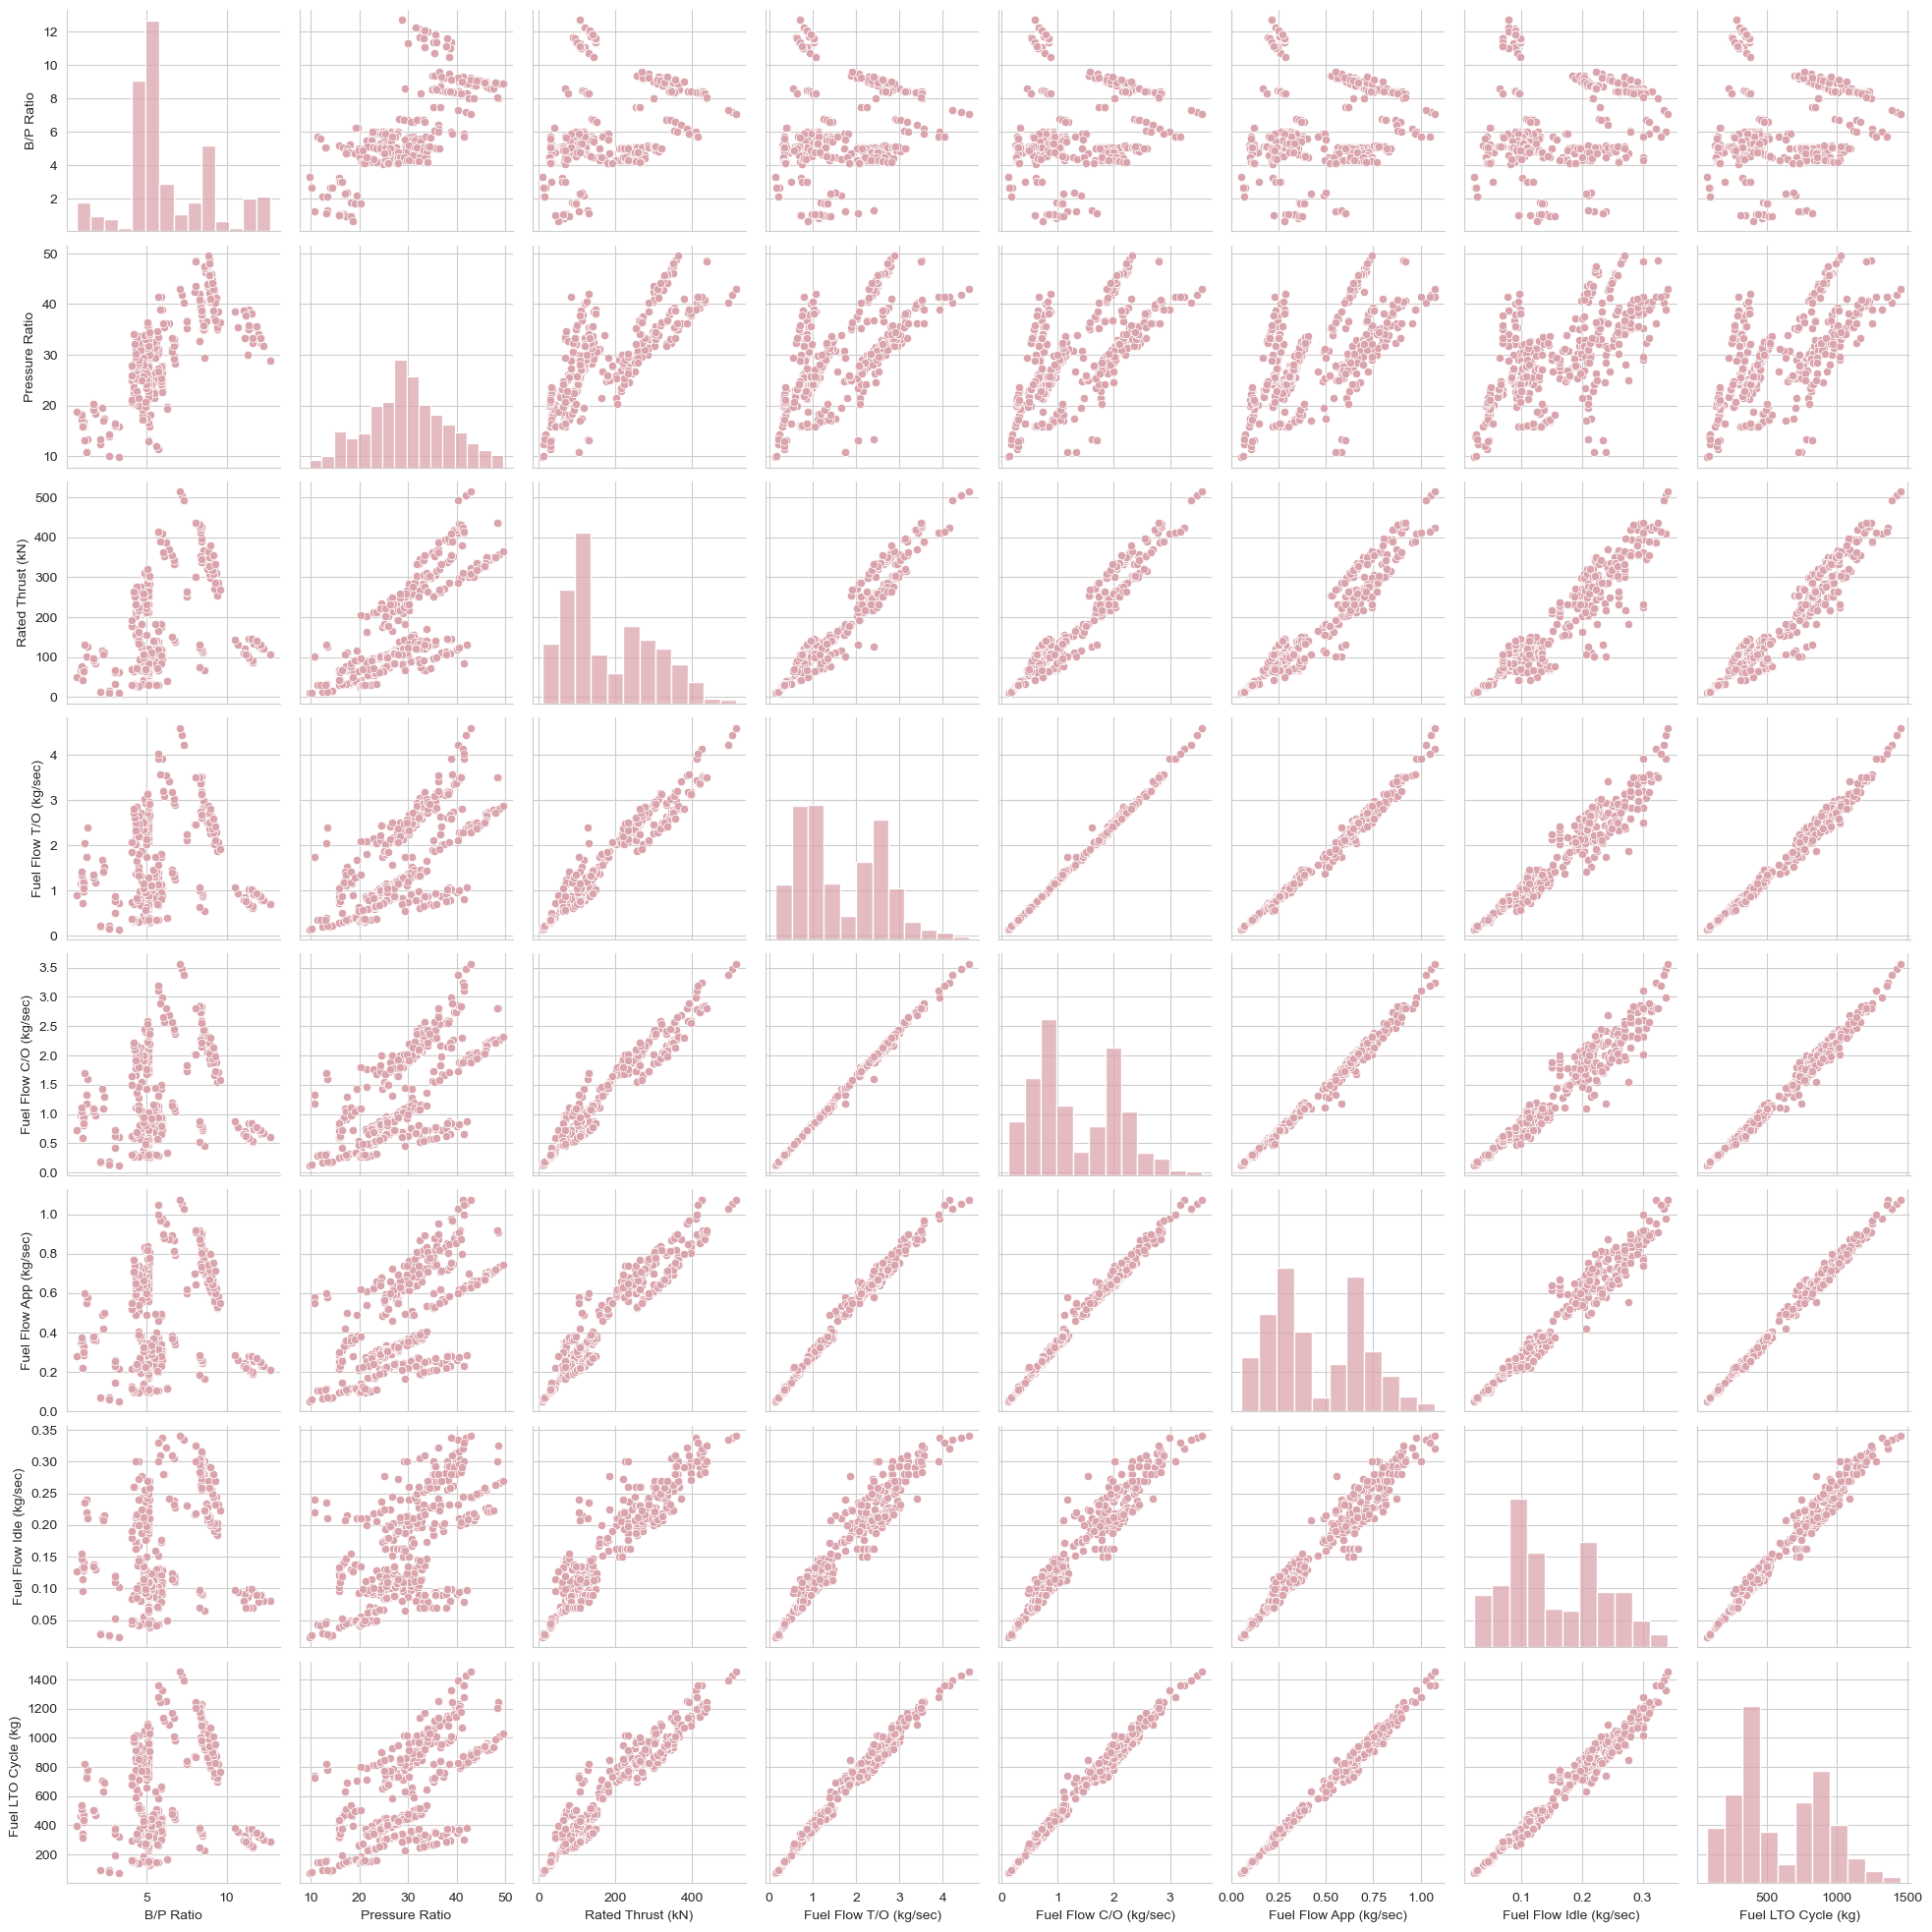

In [18]:
## Checking the relation between Engine specifications and Fuel usage values
sns.pairplot(df1.iloc[:,np.r_[2:9,77:82]], plot_kws={'color':'#daa4ac'},diag_kws={'color':'#daa4ac'})
plt.show()

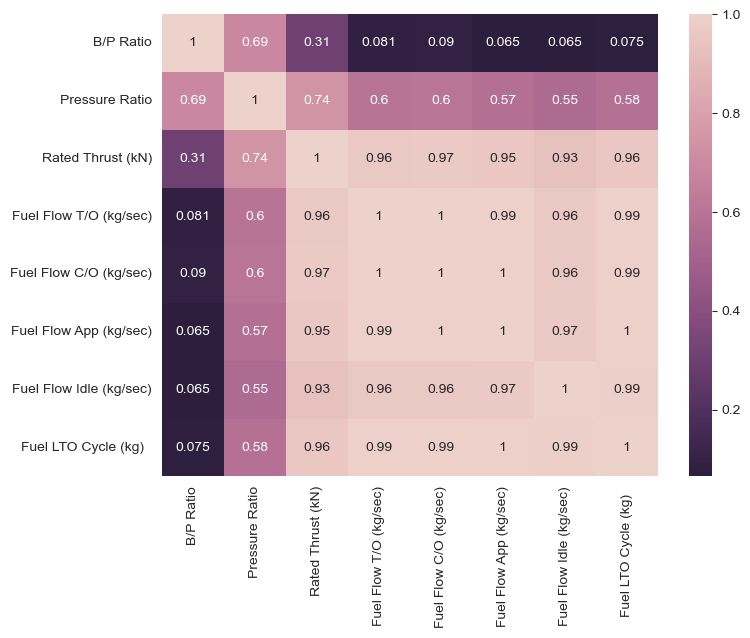

In [19]:
## Checking the correlation between Engine specifications and Fuel usage values
plt.figure(figsize=(8,6))
sns.heatmap(df1.iloc[:,np.r_[2:9,77:82]].corr(),annot=True,cmap=sns.cubehelix_palette(reverse=True,as_cmap=True))
plt.savefig('fuel_corr.png', dpi=400, bbox_inches='tight')
plt.show()

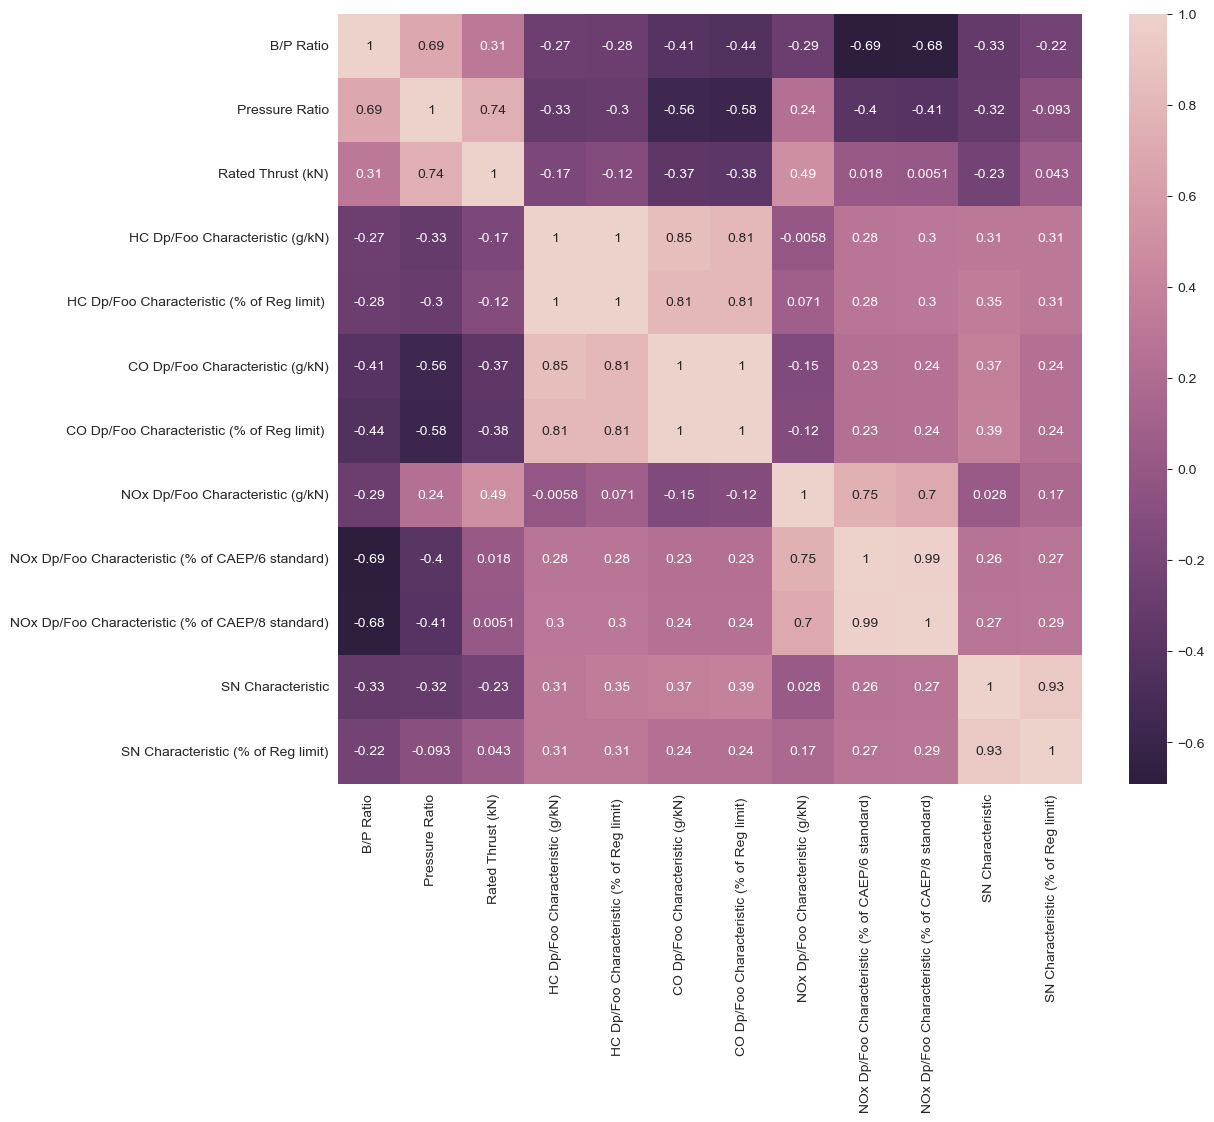

In [20]:
## Checking the correlation between engine specifications and emission characteristic values
plt.figure(figsize=(12,10))
corr_df = df1[['B/P Ratio','Pressure Ratio','Rated Thrust (kN)',
               'HC Dp/Foo Characteristic (g/kN)','HC Dp/Foo Characteristic (% of Reg limit) ',
               'CO Dp/Foo Characteristic (g/kN)','CO Dp/Foo Characteristic (% of Reg limit) ',
               'NOx Dp/Foo Characteristic (g/kN)','NOx Dp/Foo Characteristic (% of CAEP/6 standard)','NOx Dp/Foo Characteristic (% of CAEP/8 standard)',
               'SN Characteristic','SN Characteristic (% of Reg limit)',
               ]]
sns.heatmap(corr_df.corr(),annot=True,cmap=sns.cubehelix_palette(reverse=True,as_cmap=True))
plt.show()

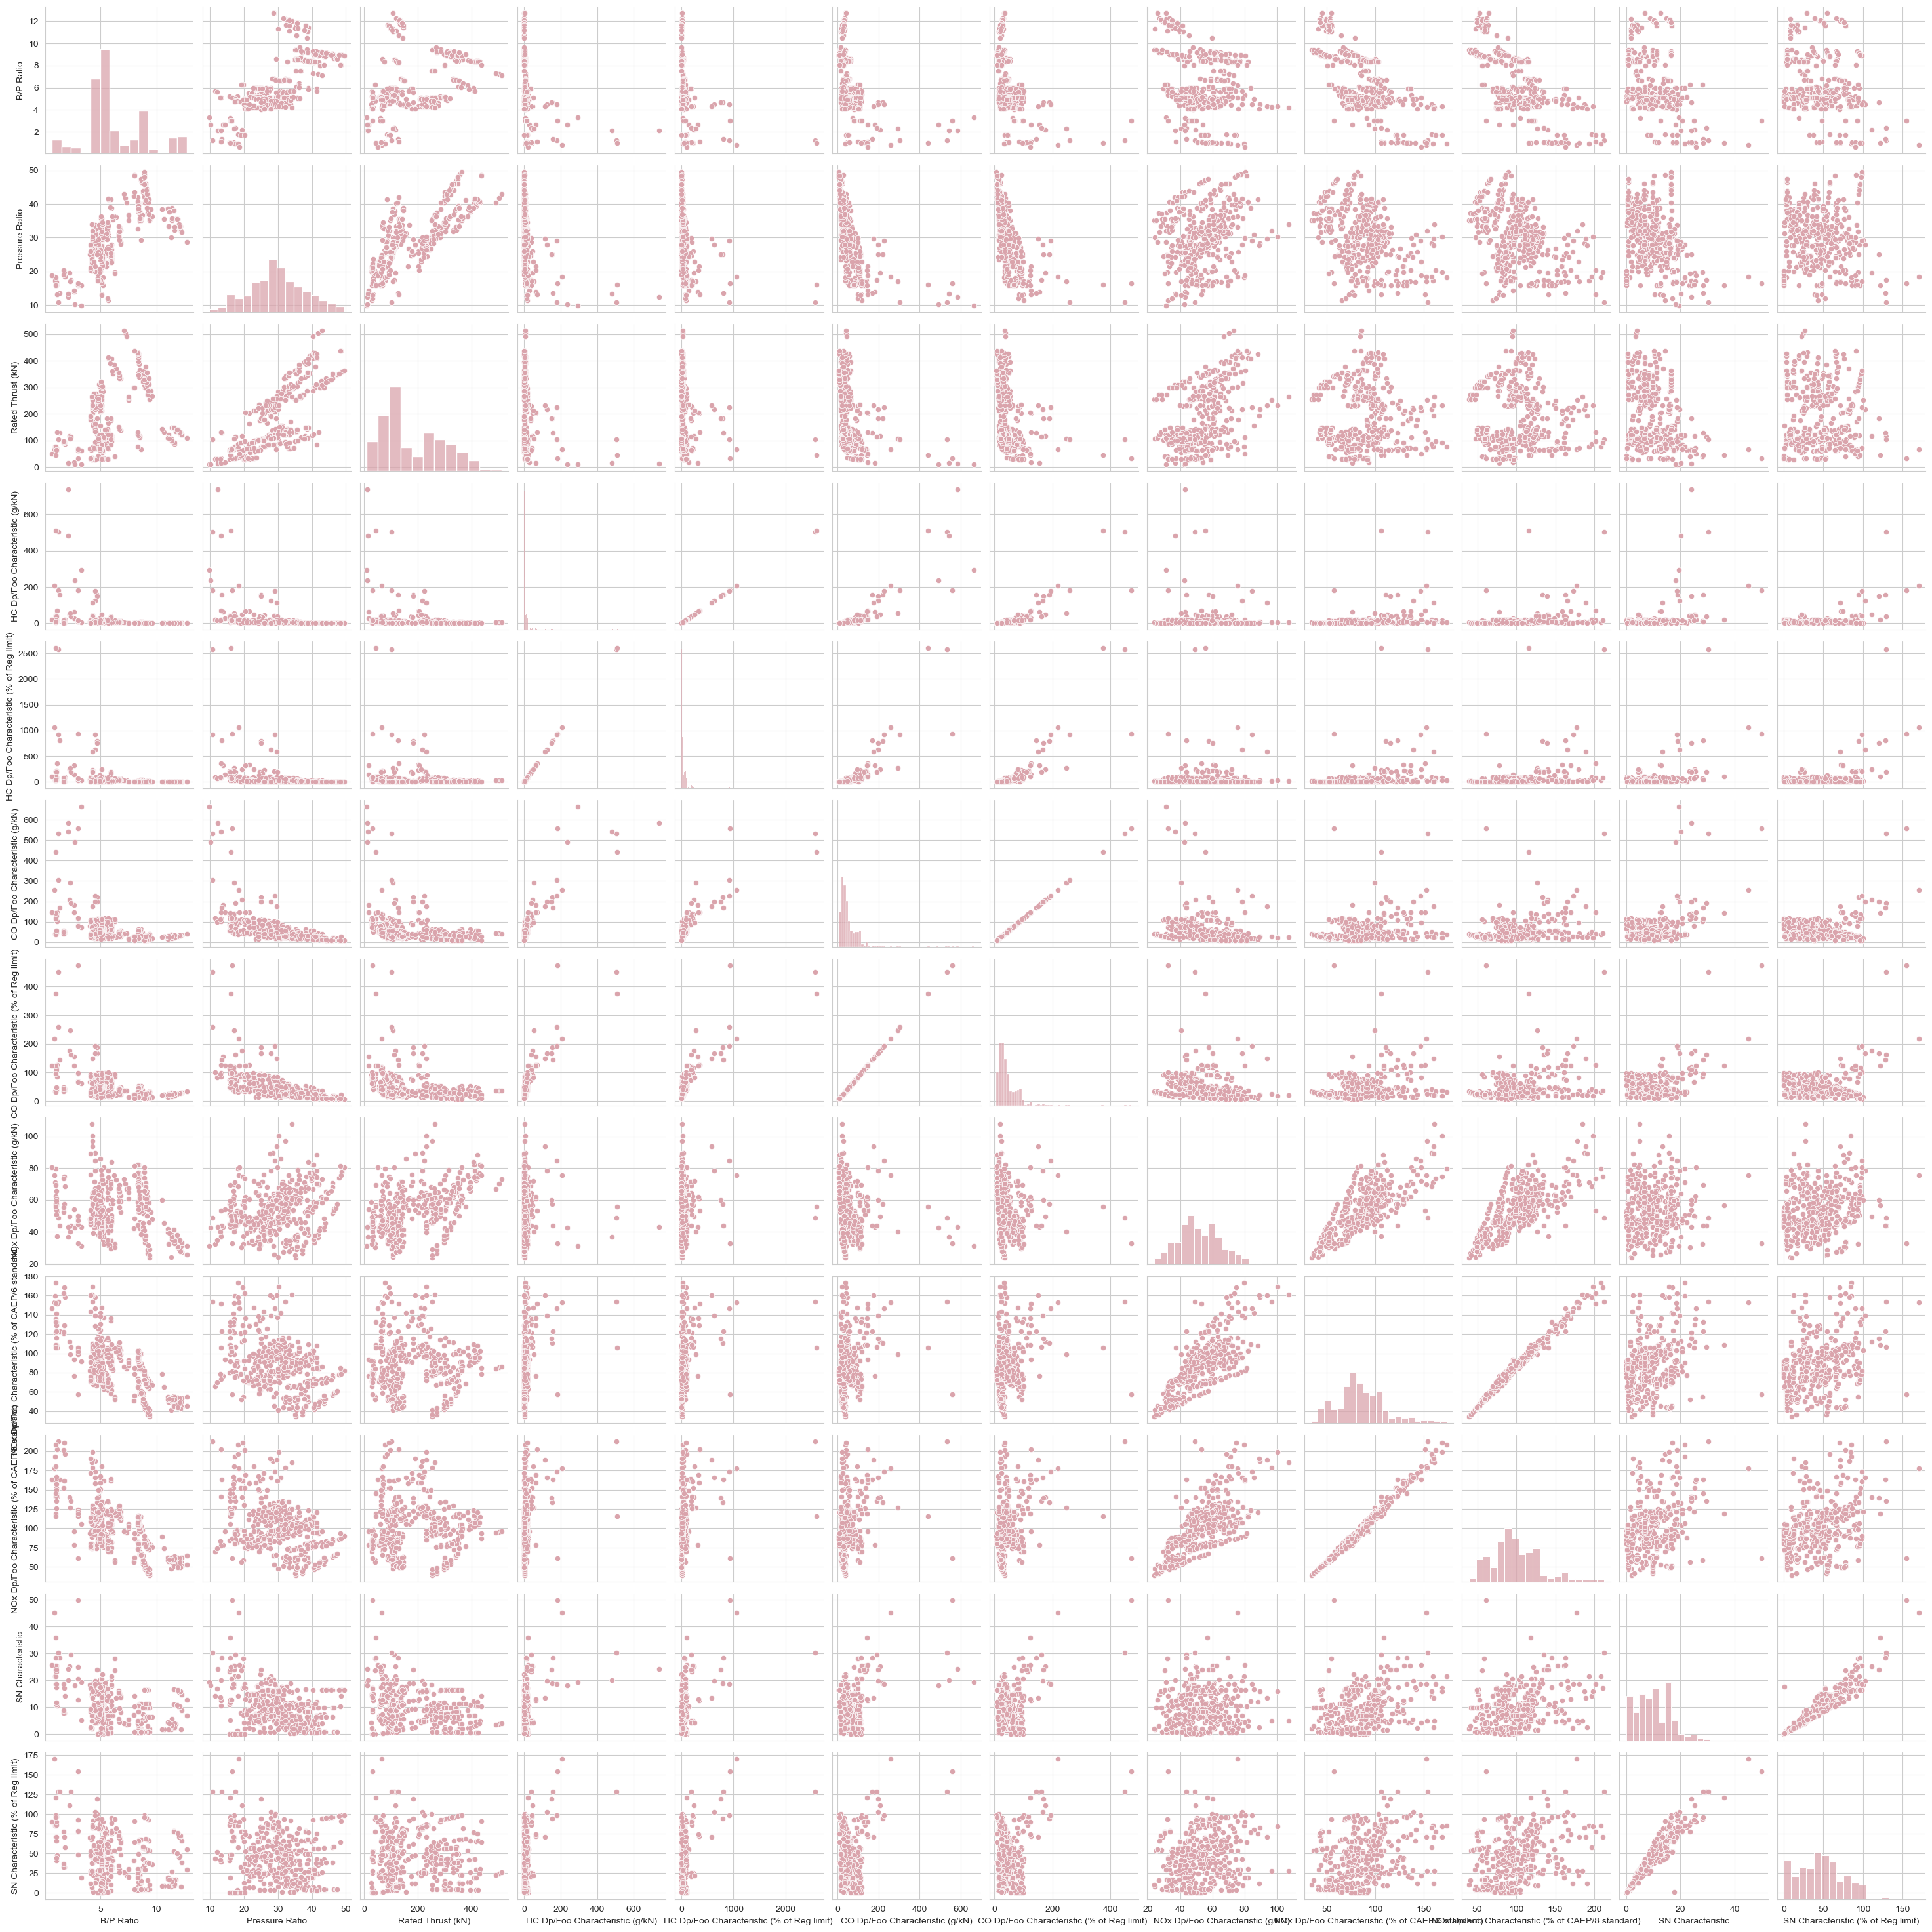

In [21]:
## Visualising the relation between engine specifications and emission characteristic values
sns.pairplot(corr_df, plot_kws={'color':'#daa4ac'},diag_kws={'color':'#daa4ac'})
plt.show()

In [22]:
## Identifying temporal trends of engine specifications and emissions
temporal_analysis_df['time_int'] = temporal_analysis_df['Initial Test Date'].apply([lambda d: int(d.replace('-',''))])
temporal_analysis_df['Initial Test Date'] = pd.to_datetime(temporal_analysis_df['Initial Test Date'])
temporal_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 2 to 814
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   B/P Ratio                         795 non-null    float64       
 1   Pressure Ratio                    795 non-null    float64       
 2   Rated Thrust (kN)                 795 non-null    float64       
 3   HC Dp/Foo Characteristic (g/kN)   795 non-null    float64       
 4   CO Dp/Foo Characteristic (g/kN)   795 non-null    float64       
 5   NOx Dp/Foo Characteristic (g/kN)  795 non-null    float64       
 6   SN Characteristic                 795 non-null    float64       
 7   Initial Test Date                 795 non-null    datetime64[ns]
 8   time_int                          795 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 62.1 KB


In [23]:
## Identifying temporal trends of engine specifications and emissions
temporal_analysis_df = temporal_analysis_df.sort_values('Initial Test Date')
temporal_analysis_df.head()

B/P Ratio  Pressure Ratio  Rated Thrust (kN)  \
474       1.40           13.60              80.06   
471       2.68           10.10              11.12   
507       5.10           22.80             213.50   
496       1.04           15.88              64.50   
504       4.90           24.50             235.80   

     HC Dp/Foo Characteristic (g/kN)  CO Dp/Foo Characteristic (g/kN)  \
474                            395.4                            328.2   
471                            235.4                            492.6   
507                             48.1                             96.1   
496                             37.6                            129.0   
504                             26.0                            107.6   

     NOx Dp/Foo Characteristic (g/kN)  SN Characteristic Initial Test Date  \
474                              37.7               63.9        1972-03-08   
471                              42.6               18.1        1973-02-01   
507                              72.0                4.3        1975-11-01   
496                              53.7               24.0        1976-04-01   
504                              63.1               10.3        1976-04-01   

     time_int  
474  19720308  
471  19730201  
507  19751101  
496  19760401  
504  19760401

In [24]:
## Applying linear regression on the data to get line of best fit/trend
x, y = np.array(temporal_analysis_df['time_int']), np.array(temporal_analysis_df.iloc[:, :7])
coeff = np.polyfit(x, y, 1)
hc_line = coeff[1, 0] + coeff[0, 0] * x

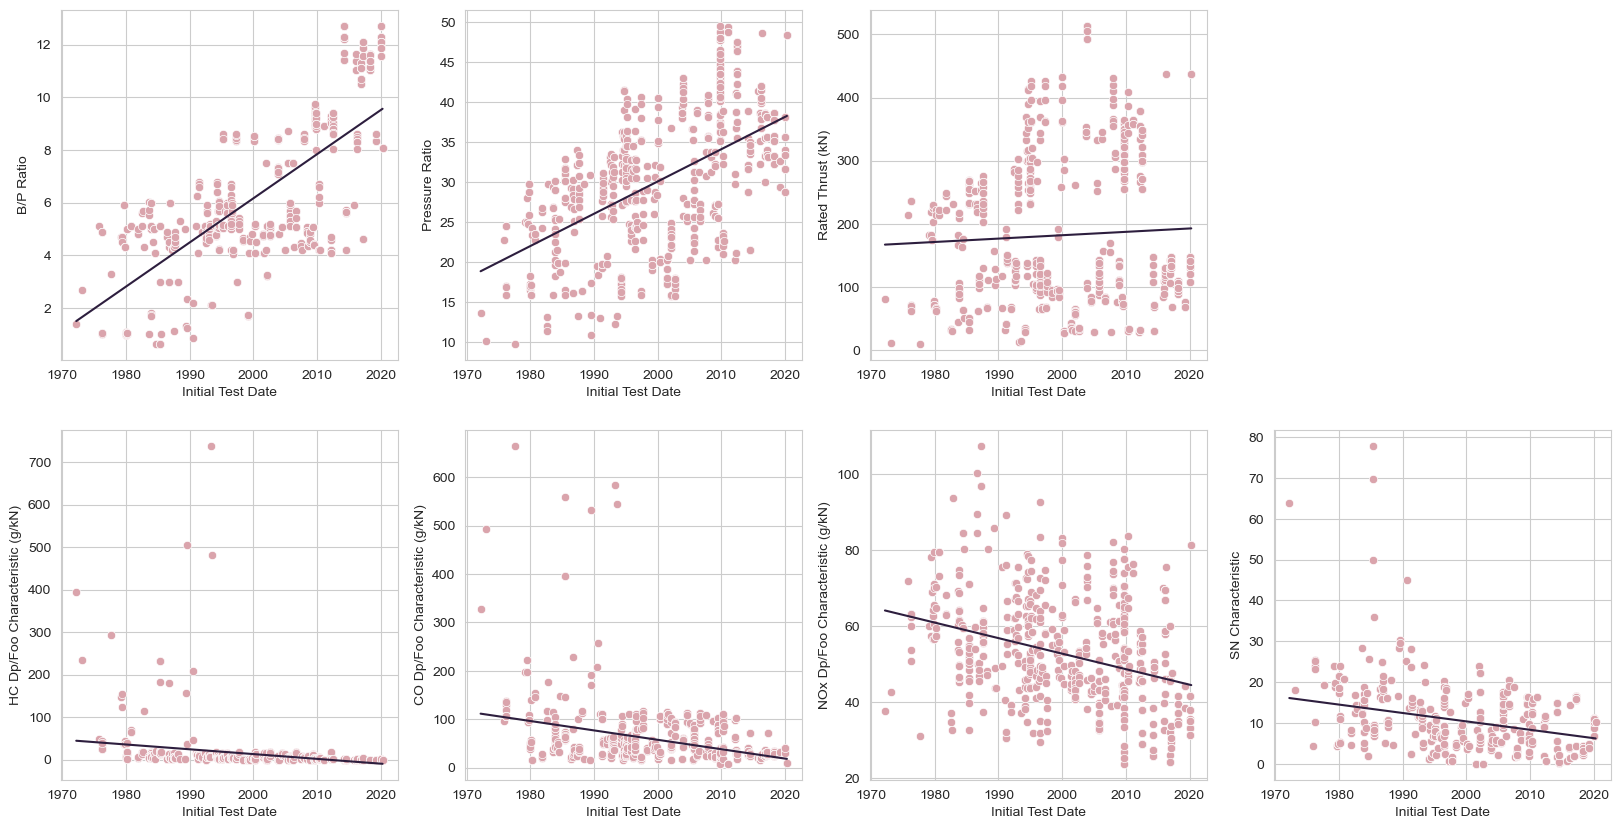

In [25]:
## Visualising temporal trends of engine specifications and emissions
plt.figure(figsize=(20,10))
for i in range(coeff.shape[1]):
    _line = coeff[1,i] + coeff[0,i]*x
    if i < 3:
        plt.subplot(2,4,i+1)
    else:
        plt.subplot(2,4,i+2)
    # plt.subplot()
    plt.plot(np.array(temporal_analysis_df['Initial Test Date'])[[0,-1]],_line[[0,-1]],color='#2d1e3e')
    sns.scatterplot(x=temporal_analysis_df['Initial Test Date'],y=temporal_analysis_df.iloc[:,i], color='#daa4ac')
    # plt.savefig(f'eda_{i}.png',dpi=400, bbox_inches='tight')
    # plt.show()
plt.show()

In [26]:
## Creating the dataframe with specific columns for clustering
characteristic_df = df1[['UID No','GSDB No','Manufacturer','Manufacturer_Group','Engine Identification','Eng Type','B/P Ratio','Pressure Ratio','Rated Thrust (kN)',
                         'HC Dp/Foo Characteristic (g/kN)','CO Dp/Foo Characteristic (g/kN)','NOx Dp/Foo Characteristic (g/kN)','NOx Dp/Foo Characteristic (% of CAEP/6 standard)',
                         'NOx Dp/Foo Characteristic (% of CAEP/8 standard)','SN Characteristic','SN Characteristic (% of Reg limit)',
                         ]].copy()
characteristic_df = characteristic_df.dropna()
indx_map = characteristic_df.index # Retaining the original index information of the data in a separate variable for later use.
characteristic_df.reset_index(drop=True,inplace=True)
characteristic_df = pd.get_dummies(characteristic_df,columns=['Eng Type'],prefix='eng_type', drop_first=True)
characteristic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 16 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   UID No                                            534 non-null    object 
 1   GSDB No                                           534 non-null    int64  
 2   Manufacturer                                      534 non-null    object 
 3   Manufacturer_Group                                534 non-null    object 
 4   Engine Identification                             534 non-null    object 
 5   B/P Ratio                                         534 non-null    float64
 6   Pressure Ratio                                    534 non-null    float64
 7   Rated Thrust (kN)                                 534 non-null    float64
 8   HC Dp/Foo Characteristic (g/kN)                   534 non-null    float64
 9   CO Dp/Foo Characteris

In [27]:
## Applying feature reduction using PCA to get 3 principal components
pca = PCA(n_components=3, random_state=42)
X_pc = pca.fit_transform(characteristic_df.iloc[:,5:])
X_pc = StandardScaler().fit_transform(X_pc)
pca_res_df = pd.DataFrame(X_pc,columns=[f'pc_{i}' for i in range(X_pc.shape[1])])
X_pc.shape

(534, 3)

### Model Selection and Application

In [28]:
## Applying clustering models on the PCA Data
dbs = cluster.DBSCAN().fit(X_pc)
brc = cluster.Birch(threshold=0.2,n_clusters=3).fit(X_pc)
wrd = cluster.AgglomerativeClustering(linkage="ward",n_clusters=3).fit(X_pc)
spc = cluster.SpectralClustering(eigen_solver="arpack",affinity="nearest_neighbors",random_state=42,n_clusters=3).fit(X_pc)
pca_res_df['dbscan'] = dbs.labels_
pca_res_df['birch'] = brc.labels_
pca_res_df['ward'] = wrd.labels_
pca_res_df['spectral'] = spc.labels_

C:\Users\jemth\anaconda3\envs\Latest Bckp\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [29]:
## Scoring the clustering models on metrics to select the best model
score_list = []
model_list = ['dbscan', 'birch', 'ward', 'spectral']
scaling_dict = {'pca': (X_pc, pca_res_df)}
for i, scaling in enumerate(scaling_dict):
    # print(scaling)
    for k in model_list:
        feat_array = scaling_dict[scaling][0]
        # print(feat_array.shape)
        results_df = scaling_dict[scaling][1]
        # print(np.array(results_df[k]).shape)
        try:
            ss = silhouette_score(feat_array, results_df[k]) # Metric close to 1 is better, negative scores are bad.
            chs = calinski_harabasz_score(feat_array, results_df[k]) # Metric with higher the score is better.
            db = davies_bouldin_score(feat_array, results_df[k]) # Metric with lower the score is better
            score_list.append((scaling, k, ss, chs, db))
        except ValueError:
            print('only one label, silhouette score not available')

model_ranking_df = pd.DataFrame(score_list, columns=['scaling', 'model', 'sil_score', 'calinski_harabasz', 'davies_bouldin'])
model_ranking_df = model_ranking_df.sort_values(['sil_score', 'calinski_harabasz', 'davies_bouldin'], ascending=[False, False, True])
model_ranking_df

scaling     model  sil_score  calinski_harabasz  davies_bouldin
1     pca     birch   0.562919          94.977118        0.541486
2     pca      ward   0.396698         219.819834        1.102036
3     pca  spectral   0.227506         141.576223        1.055717
0     pca    dbscan   0.042988          38.892260        1.734023

### Analysis of clusters and results

In [30]:
def plot_labelled_pairs(source_df, results_df, model_name: str):
    """Function to produce a pair-plot of a specific cluster model"""
    plotter_df = source_df.copy()
    plotter_df.reset_index(drop=True, inplace=True)
    plotter_df = plotter_df.merge(results_df[model_name], left_index=True, right_index=True) # LEFT JOIN the cluster labels
    sns.pairplot(plotter_df, hue=model_name, diag_kind='hist')
    plt.show()
    return plotter_df[model_name].value_counts()

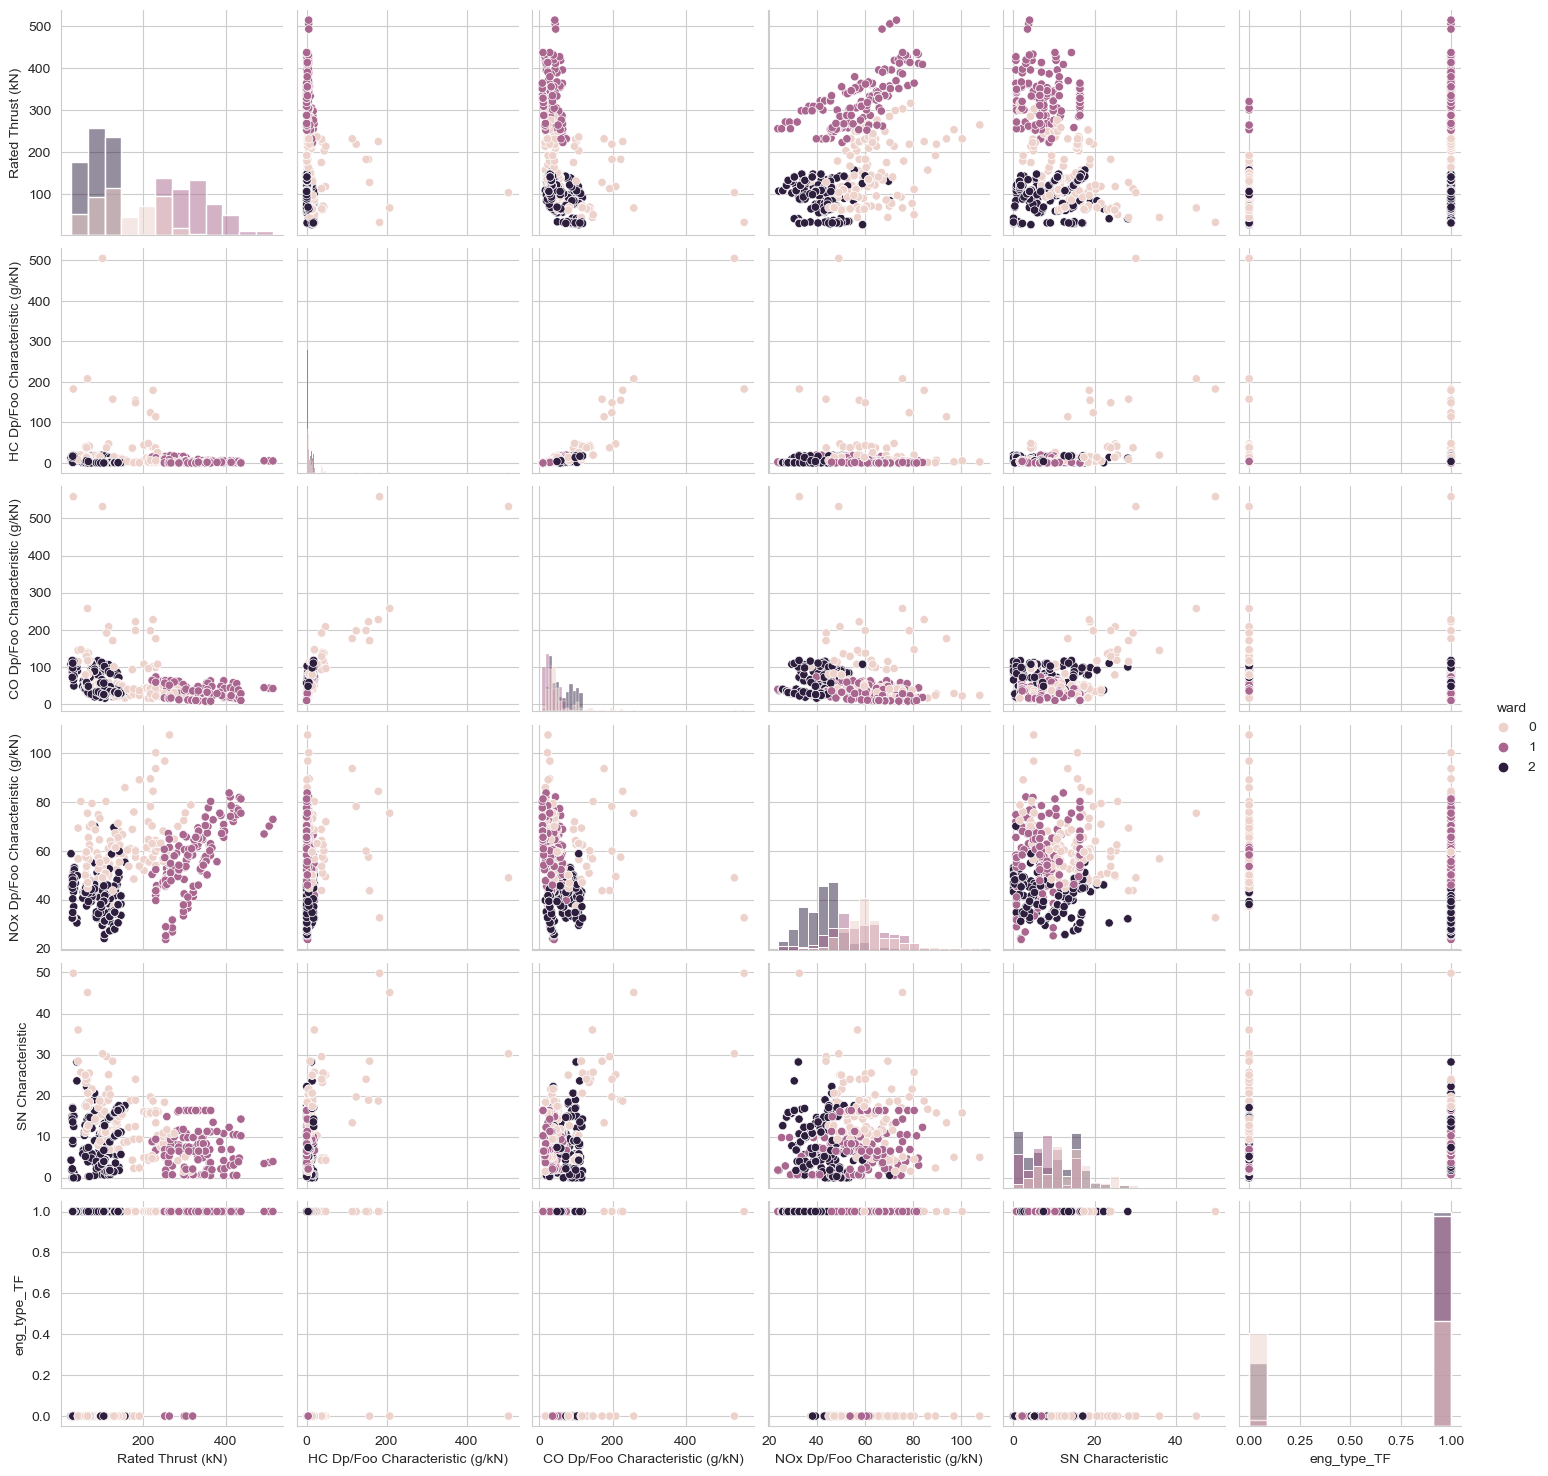

2    214
1    167
0    153
Name: ward, dtype: int64

In [31]:
plot_labelled_pairs(characteristic_df.iloc[:,np.r_[7:11,13,15]],pca_res_df,'ward')

In [32]:
## Creating temporary dataframes for different plots
dup_df = characteristic_df.copy()
dup_df = dup_df.merge(pca_res_df.iloc[:,-4:],how='left', left_index=True, right_index=True) # LEFT JOIN of cluster labels from all models
dup_df.set_index(indx_map,inplace=True)
dup_df = dup_df.merge(df1['Initial Test Date'], how='left', left_index=True, right_index=True) # LEFT JOIN date information

# Adding a few columns for box plot using LEFT JOIN
box_plot_df = dup_df.merge(df1[['UID No','HC Dp/Foo Characteristic (% of Reg limit) ','CO Dp/Foo Characteristic (% of Reg limit) ']], how='left', on='UID No')

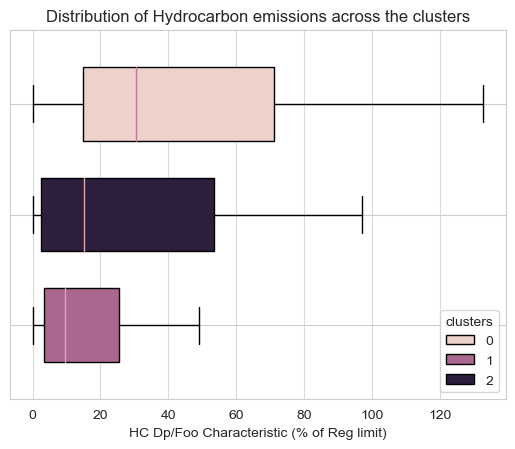

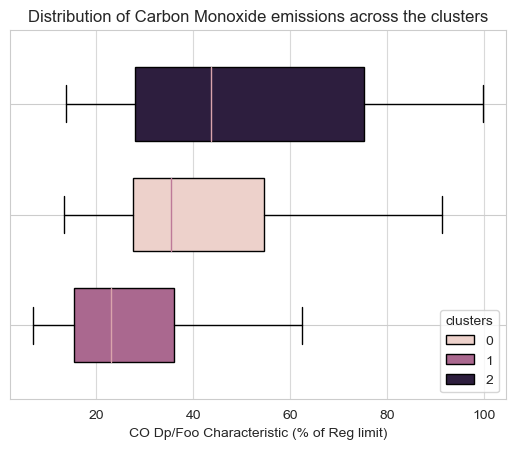

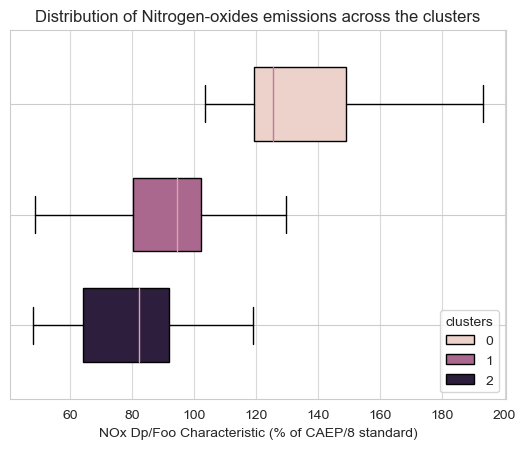

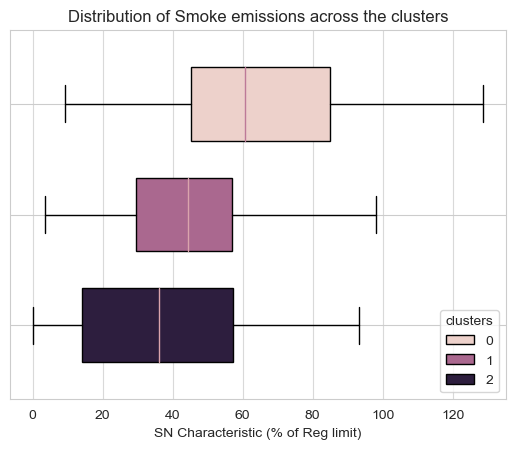

In [34]:
## Creating box plots to analyse the clusters and their respective distribution of emissions
box_plot_dict = {'HC':{'name':'HC Dp/Foo Characteristic (% of Reg limit) ',
                       'position':[0.75,-0.75,0],
                       'title':'Distribution of Hydrocarbon emissions across the clusters'},
                 'CO':{'name':'CO Dp/Foo Characteristic (% of Reg limit) ',
                       'position':[0,-0.75,0.75],
                       'title':'Distribution of Carbon Monoxide emissions across the clusters'},
                 'NO':{'name':'NOx Dp/Foo Characteristic (% of CAEP/8 standard)',
                       'position':[0.75,0,-0.75],
                       'title':'Distribution of Nitrogen-oxides emissions across the clusters'},
                 'SN':{'name':'SN Characteristic (% of Reg limit)',
                       'position':[0.75,0,-0.75],
                       'title':'Distribution of Smoke emissions across the clusters'}}

for pollutant,prop in box_plot_dict.items():
    fig_box, ax = plt.subplots()
    box1 = ax.boxplot(data=box_plot_df[box_plot_df['ward'] == 0], x=prop['name'],
                      positions=[prop['position'][0]], widths=0.5, vert=False, patch_artist=True, showfliers=False,
                      boxprops=dict(facecolor='#edd1cb'), medianprops=dict(color='#bd7a98'))
    box2 = ax.boxplot(data=box_plot_df[box_plot_df['ward'] == 1], x=prop['name'],
                      positions=[prop['position'][1]], widths=0.5, vert=False, patch_artist=True, showfliers=False,
                      boxprops=dict(facecolor='#aa688f'), medianprops=dict(color='#daa4ac'))
    box3 = ax.boxplot(data=box_plot_df[box_plot_df['ward'] == 2], x=prop['name'],
                      positions=[prop['position'][2]], widths=0.5, vert=False, patch_artist=True, showfliers=False,
                      boxprops=dict(facecolor='#2d1e3e'), medianprops=dict(color='#daa4ac'))

    ax.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0]],
              ["0", "1", "2"], loc='lower right', frameon=True, title='clusters')

    plt.xlabel(prop['name'].strip(' '))
    plt.tick_params(left=False, labelleft=False)
    plt.grid(axis='x', color='0.85')
    plt.title(prop['title'])
    # plt.savefig('box1.png', dpi=400, bbox_inches='tight')
    plt.show()


The plots above indicate that the cluster '0' can be deemed as the unwanted cluster as it results in higher emissions.

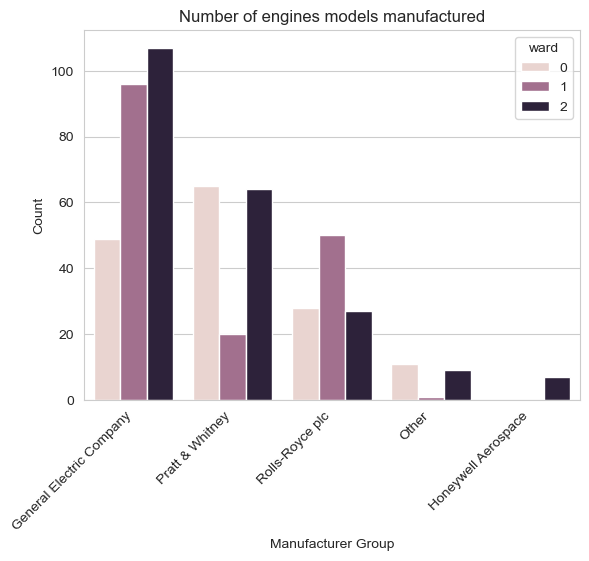

In [35]:
## Analysis of the clusters with respect to Manufacturer groups
sns.countplot(x=dup_df.Manufacturer_Group,
              hue=dup_df.ward,
              palette=sns.cubehelix_palette(3),
              order=dup_df.Manufacturer_Group.value_counts().index)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Number of engines models manufactured')
plt.xlabel('Manufacturer Group')
plt.ylabel('Count')
# plt.savefig('clustered_manufacture.png',dpi=400, bbox_inches='tight')
plt.show()

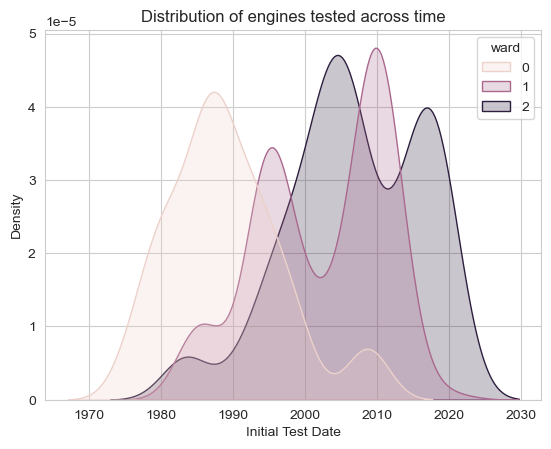

In [36]:
## Analysis of the clusters with respect to time.
sns.kdeplot(dup_df,
            x='Initial Test Date',
            hue='ward',
            palette=sns.cubehelix_palette(3),fill=True)
plt.title('Distribution of engines tested across time')
# plt.savefig('time_clustered.png', dpi=400, bbox_inches='tight')
plt.show()

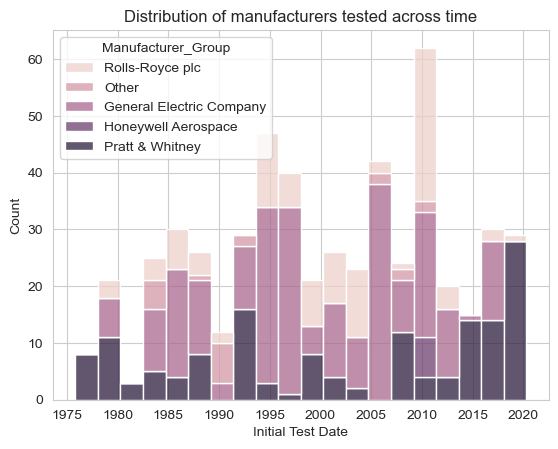

In [37]:
## Analysis of the data with respect to time and manufacturers.
hp = sns.histplot(dup_df,
                  x='Initial Test Date',
                  hue='Manufacturer_Group',
                  palette=sns.cubehelix_palette(5),
                  fill=True,
                  multiple='stack',bins=20)
sns.move_legend(hp, 'upper left')
plt.title('Distribution of manufacturers tested across time')
# plt.legend(loc='upper left', title='Manufacturer Group')
plt.show()